In [28]:
# Ensure TensorFlow uses GPU with dynamic memory growth
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"[GPU setup] {len(gpus)} Physical GPU(s) with memory growth enabled.")
else:
    print("[GPU setup] No GPU found, using CPU.")

# Suppress warnings
import os
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.model_selection import train_test_split
from tqdm import tqdm

[GPU setup] 1 Physical GPU(s) with memory growth enabled.


# Build Pretrained MobileNet****

In [30]:
def build_mobilenet(alpha=1.0, dropout_rate=0.5):
    base = MobileNet(weights='imagenet', include_top=False,
                     input_shape=(224, 224, 3), alpha=alpha)
    for layer in base.layers:
        layer.trainable = False

    x = Flatten()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=out)
    return model

# Prepare Dataset & Generators****

In [31]:
# Paths
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

data_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
val_dir  = "/kaggle/working/validation"

# Create validation split
for cls in ['REAL', 'FAKE']:
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    files = os.listdir(os.path.join(data_dir, cls))
    _, val_files = train_test_split(files, test_size=0.2, random_state=42)
    for f in val_files:
        src = os.path.join(data_dir, cls, f)
        dst = os.path.join(val_dir, cls, f)
        # Copy across filesystems instead of os.replace
        shutil.copyfile(src, dst)

# Generators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Adversarial Attack Functions****

In [32]:
@tf.function
def fgsm_attack(model, images, labels, epsilon=0.05):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        loss = tf.keras.losses.BinaryCrossentropy()(labels, preds)
    grad = tape.gradient(loss, images)
    adv = images + epsilon * tf.sign(grad)
    return tf.clip_by_value(adv, -1.0, 1.0)

@tf.function
def pgd_attack(x, y, model, loss_fn,
               epsilon=0.03, alpha=0.007, iters=10):
    x_adv = tf.identity(x)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=False)
            loss = loss_fn(y, pred)
        grad = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grad)
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
    return x_adv

# Train & Save Baseline Model

In [34]:
baseline_weights = "/kaggle/working/mobilenet_baseline.weights.h5"
baseline_model_path = "/kaggle/working/mobilenet_baseline_model.h5"

In [23]:
baseline_weights = "/kaggle/working/mobilenet_baseline.weights.h5"
baseline_model_path = "/kaggle/working/mobilenet_baseline_model.h5"

if os.path.exists(baseline_model_path):
    baseline_model = load_model(baseline_model_path)
    print("Loaded existing baseline model.")
else:
    baseline_model = build_mobilenbaseline_weights = "/kaggle/working/mobilenet_baseline.weights.h5"
baseline_model_path = "/kaggle/working/mobilenet_baseline_model.h5"et()
    baseline_model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    baseline_model.fit(
        train_gen, epochs=3, validation_data=val_gen)
    baseline_model.save_weights(baseline_weights)
    baseline_model.save(baseline_model_path)
    print("Baseline model trained and saved.")

I0000 00:00:1744981048.183396      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3


I0000 00:00:1744981058.054340      97 service.cc:148] XLA service 0x7bb220003b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744981058.055267      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744981058.620742      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3125 ━━━━━━━━━━━━━━━━━━━━ 8:11:45 9s/step - accuracy: 0.5625 - loss: 1.3570

I0000 00:00:1744981061.676077      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 732s 231ms/step - accuracy: 0.8379 - loss: 0.9941 - val_accuracy: 0.9263 - val_loss: 0.1900
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 309s 99ms/step - accuracy: 0.8942 - loss: 0.2575 - val_accuracy: 0.9329 - val_loss: 0.1643
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 267s 85ms/step - accuracy: 0.9073 - loss: 0.2224 - val_accuracy: 0.9392 - val_loss: 0.1408
Baseline model trained and saved.


# Baseline Evaluation

In [36]:
baseline_model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

In [43]:
# print("\n-- Clean Test Evaluation --")
# baseline_model.evaluate(test_gen, verbose=1)

# # FGSM sample evaluation
# x_s, y_s = next(test_gen)
# x_s = tf.convert_to_tensor(x_s)
# y_s = tf.convert_to_tensor(y_s)
# x_adv_fgsm = fgsm_attack(baseline_model, x_s, y_s)
# print("\n-- FGSM Adversarial Evaluation --")
# baseline_model.evaluate(x_adv_fgsm, y_s, verbose=1)

# # PGD sample evaluation
# x_p, y_p = next(test_gen)  # new batch for PGD
# x_p = tf.convert_to_tensor(x_p)
# y_p = tf.convert_to_tensor(y_p)
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# x_adv_pgd = pgd_attack(
#     x_p, 
#     y_p, 
#     baseline_model, 
#     loss_fn, 
#     epsilon=0.03,   # max perturbation
#     alpha=0.007,    # step size
#     iters=10        # number of iterations
# )
# print("\n-- PGD Adversarial Evaluation --")
# baseline_model.evaluate(x_adv_pgd, y_p, verbose=1)
import numpy as np
import tensorflow as tf

# Number of batches to evaluate (keeps runtime reasonable)
num_batches = 20

# Containers for accuracies
clean_accs = []
fgsm_accs  = []
pgd_accs   = []

# Ensure generator starts from the beginning
test_gen.reset()

# Loss function for PGD
loss_fn = tf.keras.losses.BinaryCrossentropy()

for i in range(num_batches):
    # Fetch a batch
    x_batch, y_batch = next(test_gen)
    
    # # 1) Clean evaluation on this batch
    # _, clean_acc = baseline_model.evaluate(x_batch, y_batch, verbose=0)
    # clean_accs.append(clean_acc)
    
    # # 2) FGSM adversarial evaluation
    # x_tensor = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    # y_tensor = tf.convert_to_tensor(y_batch, dtype=tf.float32)
    # x_adv_fgsm = fgsm_attack(baseline_model, x_tensor, y_tensor, epsilon=0.05)
    # _, fgsm_acc = baseline_model.evaluate(x_adv_fgsm, y_batch, verbose=0)
    # fgsm_accs.append(fgsm_acc)
    
    # # 3) PGD adversarial evaluation
    # x_adv_pgd = pgd_attack(
    #     x_tensor, y_tensor, baseline_model, loss_fn,
    #     epsilon=0.03, alpha=0.007, iters=10
    # )
    # _, pgd_acc = baseline_model.evaluate(x_adv_pgd, y_batch, verbose=0)
    # pgd_accs.append(pgd_acc)
# 1) Clean accuracy
    preds_clean = baseline_model(x_batch, training=False)
    acc_clean = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds_clean), y_batch), tf.float32)).numpy()
    clean_accs.append(acc_clean)

# 2) FGSM accuracy
    preds_fgsm = baseline_model(x_adv_fgsm, training=False)
    acc_fgsm = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds_fgsm), y_batch), tf.float32)).numpy()
    fgsm_accs.append(acc_fgsm)

# 3) PGD accuracy
    preds_pgd = baseline_model(x_adv_pgd, training=False)
    acc_pgd = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds_pgd), y_batch), tf.float32)).numpy()
    pgd_accs.append(acc_pgd)

 

# Print averaged results
print(f"Clean Test Accuracy (avg over {num_batches} batches): {np.mean(clean_accs):.4f}")
print(f"FGSM Accuracy      (avg over {num_batches} batches): {np.mean(fgsm_accs):.4f}")
print(f"PGD Accuracy       (avg over {num_batches} batches): {np.mean(pgd_accs):.4f}")


Clean Test Accuracy (avg over 20 batches): 0.8828
FGSM Accuracy      (avg over 20 batches): 0.0625
PGD Accuracy       (avg over 20 batches): 0.0000



 Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,074,433 (61.32 MB)

 Trainable params: 12,845,569 (49.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)


 Model Visualization:


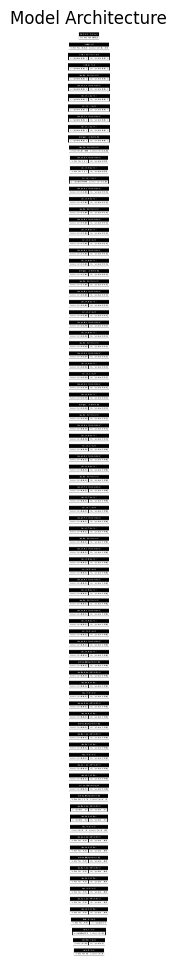


 Total Parameters: 16,074,433
 Trainable Parameters: 12,845,569
 Non-trainable Parameters: 3,228,864

⏱️ Inference Time for 1 batch (32 samples): 0.0708 seconds
 Average Time per Image: 0.0022 seconds


In [52]:
import time
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

# 1. Print Summary
print("\n Model Summary:")
baseline_model.summary()

# 2. Plot the Model Architecture
print("\n Model Visualization:")
plot_model(baseline_model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')

# Display the image in notebook
import PIL.Image
img = PIL.Image.open('model_plot.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.title("Model Architecture")
plt.show()

# 3. Count Parameters
total_params = baseline_model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in baseline_model.trainable_weights])
non_trainable_params = total_params - trainable_params
print(f"\n Total Parameters: {total_params:,}")
print(f" Trainable Parameters: {trainable_params:,}")
print(f" Non-trainable Parameters: {non_trainable_params:,}")

# 5. Inference Time Measurement (on one batch)
x_infer, _ = next(test_gen)
x_infer = tf.convert_to_tensor(x_infer)

start_time = time.time()
_ = baseline_model(x_infer, training=False)
end_time = time.time()

inference_time = end_time - start_time
print(f"\n⏱️ Inference Time for 1 batch ({x_infer.shape[0]} samples): {inference_time:.4f} seconds")
print(f" Average Time per Image: {inference_time / x_infer.shape[0]:.4f} seconds")


# Generate & Save Perturbed Training Data

In [44]:
pert_dir = "/kaggle/working/train_perturbed"
for cls in ['REAL','FAKE']:
    os.makedirs(os.path.join(pert_dir,cls), exist_ok=True)

# reload baseline
baseline_model = build_mobilenet()
baseline_model.load_weights(baseline_weights)

no_shuffle = ImageDataGenerator(preprocessing_function=preprocess_input)
no_shuffle = no_shuffle.flow_from_directory(
    data_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', shuffle=False)

loss_fn = tf.keras.losses.BinaryCrossentropy()
num_batches = len(no_shuffle)

for i in tqdm(range(num_batches)):
    xb, yb = next(no_shuffle)
    idx = no_shuffle.index_array[i*32:(i+1)*32]
    paths = [no_shuffle.filepaths[k] for k in idx]
    half = xb.shape[0]//2

    x_f = fgsm_attack(baseline_model,
                     tf.convert_to_tensor(xb[:half]),
                     tf.convert_to_tensor(yb[:half])).numpy()
    x_p = pgd_attack(tf.convert_to_tensor(xb[half:]),
                     yb[half:], baseline_model, loss_fn).numpy()
    x_comb = np.concatenate([x_f, x_p], axis=0)

    for j, pth in enumerate(paths):
        cls_name = 'REAL' if 'REAL' in pth else 'FAKE'
        fn = os.path.basename(pth).replace('.jpg', f'_adv_{i}_{j}.jpg')
        savep = os.path.join(pert_dir, cls_name, fn)
        tf.keras.preprocessing.image.save_img(savep, x_comb[j])

Found 100000 images belonging to 2 classes.


100%|██████████| 3125/3125 [23:36<00:00,  2.21it/s]


# Adversarial Training & Saving

In [45]:
pert_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
pert_gen = pert_gen.flow_from_directory(
    pert_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', shuffle=True)

adv_model = build_mobilenet()
adv_model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
adv_model.fit(pert_gen, epochs=3, validation_data=val_gen)
adv_model.save('/kaggle/working/mobilenet_adv_model.h5')

Found 100000 images belonging to 2 classes.
Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 144s 44ms/step - accuracy: 0.9317 - loss: 0.7026 - val_accuracy: 0.3103 - val_loss: 1.7897
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 139s 44ms/step - accuracy: 0.9704 - loss: 0.0796 - val_accuracy: 0.2986 - val_loss: 1.6718
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 134s 43ms/step - accuracy: 0.9760 - loss: 0.0644 - val_accuracy: 0.2882 - val_loss: 1.5459


# Robustness Evaluation

In [49]:

# FGSM adversarial evaluation
x_t, y_t = next(test_gen)
x_t_tensor = tf.convert_to_tensor(x_t)
y_t_tensor = tf.convert_to_tensor(y_t)
x_adv_fgsm = fgsm_attack(adv_model, x_t_tensor, y_t_tensor, epsilon=0.05).numpy()
fgsm_loss, fgsm_acc = adv_model.evaluate(x_adv_fgsm, y_t, verbose=0)
print(f"FGSM Accuracy on Robust Model: {fgsm_acc:.4f}")

# PGD adversarial evaluation
# Fetch a fresh batch (so we don't reuse the same samples)
x_p, y_p = next(test_gen)
x_p_tensor = tf.convert_to_tensor(x_p)
y_p_tensor = tf.convert_to_tensor(y_p)

# Run PGD 
x_adv_pgd = pgd_attack(
    x_p_tensor,
    y_p_tensor,
    adv_model,
    loss_fn,
    epsilon=0.03,   # max perturbation
    alpha=0.007,    # step size
    iters=10        # iterations
).numpy()

pgd_loss, pgd_acc = adv_model.evaluate(x_adv_pgd, y_p, verbose=0)
print(f"PGD Accuracy on Robust Model: {pgd_acc:.4f}")


FGSM Accuracy on Robust Model: 0.3125
PGD Accuracy on Robust Model: 0.1562
